In [1]:
import regex as re

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
with open("./basic_corp_001.txt", "r", encoding="utf-8") as file:
    corpus = file.read()
# sample
corpus[:1000]

'Deep learning revolutionized natural language processing (NLP)\nby offering powerful techniques for extracting meaning from textual data.\nAt its core, deep learning is a subset of machine learning that employs neural networks\nwith multiple layers to model and extract intricate patterns from data.\nIn NLP, this manifests in various architectures like recurrent neural networks (RNNs),\nconvolutional neural networks (CNNs), and more notably, transformers. Transformers,\nintroduced by the seminal "Attention is All You Need" paper, have become a cornerstone in modern NLP\ndue to their ability to capture long-range dependencies and contextual information effectively.\nOne of the most renowned transformer models is BERT (Bidirectional Encoder Representations from Transformers),\nwhich pre-trains a deep bidirectional representation of text using a large corpus of data.\nThis pre-training allows BERT to grasp intricate linguistic nuances and semantics,\nmaking it exceptionally adept at tasks

```text
    training data should look like:
    
    <center>       ->    <context>
    [0, ..., 1, 0] ->    [0, ..., 1, 0]
    [0, ..., 1, 0] ->    [0, ..., 0, 1]
    [0, ..., 1, 0] ->    [1, ..., 0, 0]
    ...            ->    ...
    
    where the center word (input) have a number of <context words>
    based on the size of the window hence:
        if window_size = 2; two context words from both sides (left & right).
    
    objective:
        based on the given input <center word> try to predict the output <context word>
        and when we reach to a good performance we hope that the neural network will
        try to extract hiddin features, which are going to be the meanings of input words
        in a numerical representation.
        
    steps:
        1. split input text into chunks (tokens)
        2. assign a token_id per token
        3. encode thoes tokens based on their ids (one-hot encoding)
        4. building the training data as intended above
        5. 
    
    NOTE: this is going to be the basic solution and from here i'll try to improve.
```
    


In [3]:
def tokenize(text):
    # simple tokenizer
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def encode(token_id, vocab_size):
    vector = [0] * vocab_size  # which is going to be the input vector size
    vector[token_id] = 1
    return np.array(vector)  # for training (later)

In [4]:
tokens = tokenize(corpus)
tokens[:8]

['deep',
 'learning',
 'revolutionized',
 'natural',
 'language',
 'processing',
 'nlp',
 'by']

In [5]:
token_to_id = {t: i for i, t in enumerate(set(tokens))}
id_to_token = {i: t for i, t in enumerate(set(tokens))}

In [6]:
vocab_size = len(set(tokens))
vocab_size

332

In [7]:
def combine(*iterables):
    # to combine two iterables
    # into single iterable
    for iterable in iterables:
        yield from iterable

def build_train(tokens, token_to_id, vocab_size, window_size=2, verbose=False):
    center_vectors = []
    context_vectors = []
    for i, center in enumerate(tokens):
        # context words iterable on the right side
        r_ctx = range(i+1, min(i+window_size+1, len(tokens)))
        # context words iterable on the left side
        l_ctx = range(max(0, i-window_size), i)
        # combined context iterables from both sides
        c_ctx = combine(l_ctx, r_ctx)
    
        # get numerical representation (one-hot encoding)
        # for both: 1. center word 2. context word    
        cnt_w_id = token_to_id[center]  
        cnt_w_vector = encode(cnt_w_id, vocab_size)  # 1. center word
        for w_id in c_ctx:
            if verbose:
                # <center word>  ->  <ctx word>
                print(f"{center} -> {tokens[w_id]}")
                
            ctx_w_id = token_to_id[tokens[w_id]]
            ctx_w_vector = encode(ctx_w_id, vocab_size)  # 2. context word
            
            center_vectors.append(cnt_w_vector)
            context_vectors.append(ctx_w_vector)
    # store them as numpy.array for training        
    return np.array(center_vectors), np.array(context_vectors)

In [8]:
cnt, ctx = build_train(tokens, token_to_id, vocab_size)
print("center words shape: ", cnt.shape)
print("context words shape: ", ctx.shape)

center words shape:  (3482, 332)
context words shape:  (3482, 332)


```text
    center words are duplicated:
    where the same center word has more than context words
    the size depends on the `window_size`
    
    center word (1) -> context word (1)
                    -> context word (2)
                    -> ...
                    -> context word (N)
    ...
    center word (M) -> context word (1)
                    -> context word (2)
                    -> ...
                    -> context word (N)
```

```text

    Forward pass:
    -------------
    A1   = X @ W1
    A2   = A1 @ W2
    Z    = softmax(A2)
    Loss = cross_entropy(Z, y)
    
    
    How changing W2 impacted the loss?
    ----------------------------------
    >> dLoss(Z, y)/dW2 = dLoss/dZ * dZ/dA2 * dA2/dW2 
    >> dLoss(Z, y)/dW2 = (z - y)           * A1
    shape convention:
    - (z - y): (#samples, vocab_size)
    - A1:      (#samples, embedding_size)
    
    shape of target matrix to update (W2): (embedding_size, vocab_size)
    
    ==> A1.T @ (z-y)
    
    
    How changing W1 impacted the loss?
    ----------------------------------
    >> dLoss(Z, t)/dW1 = dLoss/dZ * dZ/dA2 * dA2/dA1 * dA1/dW1
    >> dLoss(Z, t)/dW1 = (z - y)           * W2      * X
    
    shape convention:
    - (z - y): (#samples, vocab_size)
    - W2:      (embedding_size, vocab_size)
    - X:       (#samples, vocab_size) 
    
    shape of target matrix to update (W1): (vocab_size, embedding_size)
    
    ==> x.T @ ( (z-y) @ W2.T )
```
    

In [15]:
class Model:
    def __init__(self, X, y, vocab_size, embedding_size):
        self.X = X
        self.y = y
        self.vocab_size = vocab_size
        self.w1 = np.random.randn(vocab_size, embedding_size)
        self.w2 = np.random.randn(embedding_size, vocab_size)
    
    def forward(self):
        self.a1 = self.X @ self.w1  # (vocab_size, embedding_size)
        self.a2 = self.a1 @ self.w2  # (tokens, vocab_size)
        self.z = self._softmax(self.a2)  # (tokens, vocab_size)
        return self.z
    
    def backward(self, alpha):
        self.forward()
        # derivatives
        dl = self.z - self.y
        dw2 = self.a1.T @ dl
        dw1 = self.X.T @ (dl @ self.w2.T)
        # shape validation
        assert(dw2.shape == self.w2.shape)
        assert(dw1.shape == self.w1.shape)
        # update weights
        self.w1 = self.w1 - (alpha * dw1)
        self.w2 = self.w2 - (alpha * dw2)
        # compute loss
        return self._cross_entropy(self.y, self.z)
    
    @staticmethod    
    def _softmax(a):
        # avoide numerical overflow
        a = a - np.max(a, axis=1, keepdims=True)
        exp_a = np.exp(a)
        return exp_a / np.sum(exp_a, axis=1, keepdims=True)
    
    @staticmethod
    def _cross_entropy(actual, predicted, epsilon=1e-10):
        predicted = np.clip(predicted, epsilon, 1 - epsilon)
        return - np.sum(actual * np.log(predicted))

embedding size: 2 - epoch: 0 - loss: 23305.215231795537
embedding size: 2 - epoch: 50 - loss: 18313.695689474836
embedding size: 2 - epoch: 100 - loss: 17249.98081318332
embedding size: 2 - epoch: 150 - loss: 16890.230425664176
embedding size: 2 - epoch: 200 - loss: 16721.49935481394
embedding size: 10 - epoch: 0 - loss: 36092.257126797005
embedding size: 10 - epoch: 50 - loss: 15763.926249625012
embedding size: 10 - epoch: 100 - loss: 13638.867000713422
embedding size: 10 - epoch: 150 - loss: 12636.406558032699
embedding size: 10 - epoch: 200 - loss: 12041.882146092983
embedding size: 30 - epoch: 0 - loss: 54365.52740650801
embedding size: 30 - epoch: 50 - loss: 12607.758440254547
embedding size: 30 - epoch: 100 - loss: 10186.009634674003
embedding size: 30 - epoch: 150 - loss: 9576.567637181912
embedding size: 30 - epoch: 200 - loss: 9299.906381399343
embedding size: 50 - epoch: 0 - loss: 66173.22647067081
embedding size: 50 - epoch: 50 - loss: 10957.414553109478
embedding size: 50 -

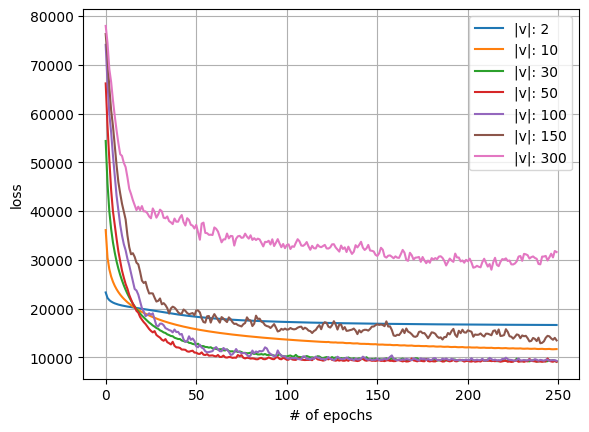

CPU times: user 10min 26s, sys: 43.2 s, total: 11min 10s
Wall time: 1min 33s


In [16]:
%%time
np.random.seed(42)
n_epochs = 250
alpha = 0.005
embedding_sizes = [2, 10, 30, 50, 100, 150, 300]

for embedding_size in embedding_sizes:
    model = Model(cnt, ctx, vocab_size, embedding_size)
    history = []
    epochs = []
    for epoch in range(n_epochs):
        loss = model.backward(alpha)
        if not epoch % 50:
            print(f"embedding size: {embedding_size} - epoch: {epoch} - loss: {loss}")
        history.append(loss)
        epochs.append(epoch)
        
    plt.plot(epochs, history, label=f"|v|: {embedding_size}")
        
    print("=" * 60)


plt.ylabel("loss")
plt.xlabel("# of epochs")
plt.grid()
plt.legend()
plt.show()

In [13]:
# def get_relevant_words(w):
#     token_id = token_to_id[w]
#     similarites = model.w1 @ model.w1[token_id]
#     most_similar = np.argsort(similarites)[::-1][:10]
    
#     for i, tid in enumerate(most_similar):
#         print(f"word #{i}: {id_to_token[tid]}")

In [14]:
# get_relevant_words("deep")